<a href="https://colab.research.google.com/github/kenichinakanishi/houseplant_classifier/blob/master/Part_4_Geffnet_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Check GPU on Colabs
# NVIDIA-SMI 455.32.00 Driver Version: 418.67 CUDA Version: 10.1 Tesla V100-SXM2
! nvidia-smi 

Sun Nov 29 23:36:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Run once per session
!pip install fastai==2.1.2 -q
!pip install fastcore==1.3.1 -q
!pip install torch==1.7.0 -q
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.callback.cutmix import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from fastai.vision.models.xresnet import *
from fastcore.script import *
fastprogress.MAX_COLS = 80

     |████████████████████████████████| 194kB 13.6MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 


In [ ]:
torch.cuda.is_available()

True

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil -q
!pip install psutil -q
!pip install humanize -q
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [ ]:
printm()

Gen RAM Free: 26.3 GB  | Proc size: 301.7 MB
GPU RAM Free: 16120MB | Used: 10MB | Util   0% | Total 16130MB


# Download and Unzip the File

The use of images directly from a google drive is very slow.
This is because even though the drive appears to be direcly attached to our colab instance, in actuality we are dynamically downloading and accessing each image one by one - leading to extremely long training times. 

At this point, I've gone to the directory the image files were downloaded to, zipped them up and placed that master zip file into my google drive for importing and processing. 

In [ ]:
# If your zip file is on your google drive - download it into the current kernel
!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_database_manualcleanedlosses10.zip' 'plant_images_database_manualcleanedlosses10.zip'
# This code snippet unzips a zip file to a specified destination
!unzip -q "/content/plant_images_database_manualcleanedlosses10.zip" -d "/content";

plant_images_database_manualcleanedlosses10/Citrus ×aurantium/:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000000.jpg:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/00000000.jpg),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000001.jpg:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/00000001.jpg),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000002.jpg:  mismatching "local" filename (plant_images_database_manualcleanedlosses10/Citrus ├Чaurantium/00000002.jpg),
         continuing with "central" filename version
plant_images_database_manualcleanedlosses10/Citrus ×aurantium/00000003.jpg: 

In [ ]:
# If your zip file is on your google drive - download it into the current kernel
!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_database.zip' 'plant_images_database.zip'
# This code snippet unzips a zip file to a specified destination
!unzip -q "/content/plant_images_database.zip" -d "/content";

plant_image_database/Citrus ×aurantium/:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000000.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000000.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000001.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000001.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000002.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000002.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000003.jpg:  mismatching "local" filename (plant_image_database/Citrus ├Чaurantium/00000003.jpg),
         continuing with "central" filename version
plant_image_database/Citrus ×aurantium/00000004.jpg:  mismatching "lo

# Set Up Model

In [ ]:
def random_seed(seed_value, use_cuda):
  '''
  Sets the random seed for numpy, pytorch, python.random and pytorch GPU vars.
  '''
  np.random.seed(seed_value) # Numpy vars
  torch.manual_seed(seed_value) # PyTorch vars
  random.seed(seed_value) # Python
  if use_cuda: # GPU vars
      torch.cuda.manual_seed(seed_value)
      torch.cuda.manual_seed_all(seed_value) 
      torch.backends.cudnn.deterministic = True 
      torch.backends.cudnn.benchmark = False
  print(f'Random state set:{seed_value}, cuda used: {use_cuda}')

In [ ]:
@call_parse
def create_path_df(
      path: Param("Path of images to use", str), 
      pct_images: Param("Fraction of images to use", float)=1,
      shuffle: Param("Shuffle prior to splitting", bool)=False,
      ):
  '''
  Creates a dataframe with respective classes and path to images.
  Can return a subset of those images based on the pct_images.
  By default will return the earliest files in the path.

  Returns:
  ----------
  DataFrame
    Returns a dataframe with Class and Path columns. 
  '''
  from sklearn.utils import shuffle as shuff
  data = []
  for folder in sorted(os.listdir(path)):
      num_files = len(sorted(os.listdir(path+'/'+folder)))
      cut_point = int(num_files*pct_images)
      # Takes the first pct_images from each folder
      if shuffle == True:
        for file in shuff(os.listdir(path+'/'+folder))[:cut_point]:
          data.append((folder, path+folder+'/'+file))
      else:
        for file in sorted(os.listdir(path+'/'+folder))[:cut_point]:
          data.append((folder, path+folder+'/'+file))
  df = pd.DataFrame(data, columns=['Class', 'Path'])
  print(f'Creating path:label dataframe from {path}, using {pct_images*100:.2f}% of the images ({len(df)} images.) Shuffle = {shuffle}.')
  return df

In [ ]:
@call_parse
def stratified_split(
      dataframe: Param("DataFrame created from create_path_df, containing Class and Path columns."), 
      n_splits: Param("Number of folds in split", int)=5,
      shuffle: Param("Shuffle prior to splitting", bool)=True,
      fold: Param("Which fold to use", int)=0,
      random_state: Param("Fix randomness if shuffle==True", int)=101,
      ):
  ''' 
  Prepares a stratified k-fold split from a dataframe with 'Class' and 'Path' by adding an 'is_valid' column.

  Returns:
  ----------
  DataFrame
    Returns the requested stratified k-fold split by adding an 'is_valid' column. 
  '''
  from sklearn.model_selection import StratifiedKFold
  # Create stratified split using sklearn
  print(f'Preparing stratified {n_splits} fold split, random state is {random_state}. Returning fold {fold}.')
  kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state = random_state)
  X, y = dataframe['Path'], dataframe['Class']
  splits = list(kf.split(X, y))
  # Prepare the selected fold
  fold = fold
  train_df = dataframe.loc[splits[fold][0]]
  val_df = dataframe.loc[splits[fold][1]]
  train_df['is_valid'] = False
  val_df['is_valid'] = True
  df_cnn = train_df.append(val_df)
  # Return the selected fold
  return df_cnn

In [ ]:
@call_parse
def get_dataloader(
      img_path: Param("Path of images to use", str),
      split_path: Param("Path of images to use to pre-define split", str)=None,
      img_size:  Param("Size in pixels", int)=224,
      pct_images: Param("Fraction of images to use", float)=1,
      bs: Param("Batch size", int)=64,
      deterministic: Param("Deterministic learner", bool)=True,
      randomerasing: Param("Random Erasing", str)=None,
      n_splits: Param("Number of folds in split", int)=5,
      shuffle: Param("Shuffle prior to splitting", bool)=True,
      fold: Param("Which fold to use", int)=0,
      ):
  """ 
  Takes in image path and creates a dataloader. 
  If a split_path is defined, uses the entirety of that path to generate a master split, onto which the img_path is joined to defined a pseudo split.  
      
  Returns:
  ----------
  Dataloader
    dls = data.dataloaders(df_cnn_mini, bs=bs)
  """

  # Get file path and labels from the dataframe we set up.
  get_x = lambda x: x['Path']
  get_y = lambda y: y['Class']
  # Define splitting function that reads from a dataframe column.
  def stratifiedsplitter(df):      
      train = df.index[~df['is_valid']].tolist()
      valid = df.index[df['is_valid']].tolist()
      return train,valid   
  # Prepare transforms
    # Image is larger initially (512 px) for later augmentations.
  item_tfms=[RandomResizedCrop(512, min_scale = 0.7)]
    # Batch transformations include a random resized crop to img_size px. 
  batch_tfms=[*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats)]
  # Add in randomerasing if necessary.
  if randomerasing != None:
    batch_tfms=[*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats), randomerasing]
  # Prepare DataBlock
  data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=stratifiedsplitter,            # Stratified train/validation split
                    get_x=get_x,                            # Get the image path from dataframe
                    get_y=get_y,                            # Label from dataframe
                    item_tfms=item_tfms,                    # Crop images to a square
                    batch_tfms=batch_tfms)                  # Normalize the images based on the imagenet stats
  if split_path != None:
    print('Split Path defined, preparing pseudo stratified split.')
    # Create split_df - a dataframe that defines a master split, based on split_path
    df = create_path_df(split_path, pct_images=1)
    split_df = stratified_split(df, n_splits = 5, shuffle = True, random_state = 101, fold = 0)
    split_df['Path']= split_df['Path'].apply(lambda x:img_path+'/'.join(x.split('/')[-2:]))
    # Inner join this reduced dataframe to the previous splits to maintain the same training images
    df_mini = create_path_df(img_path, pct_images=pct_images)
    df_cnn_mini= df_mini.merge(split_df, how = 'inner', on = ['Class','Path'])
  else: 
    # Create a dataframe based on main image path with a (possibly) reduced number of images
    df = create_path_df(img_path, pct_images=pct_images)
    df_cnn_mini = stratified_split(df, n_splits = 5, shuffle = True, random_state = 101, fold = 0)
  # Print some information for a sanity check
  dls = data.dataloaders(df_cnn_mini, bs=bs)
  print(f'We have {dls.c} classes, with a training set of size {len(dls.train_ds)}, and a validation set of size {len(dls.valid_ds)}')
  if split_path != None:
    print(f"The main split has {split_df['is_valid'].describe()['freq']/len(split_df['is_valid'])*100:.2f}% training data with {len(split_df.groupby('Class').count())} classes, the reduced split has {df_cnn_mini['is_valid'].describe()['freq']/len(df_cnn_mini['is_valid'])*100:.2f} % training data, with {len(df_cnn_mini.groupby('Class').count())} classes.")
  return dls

In [ ]:
@call_parse
def create_simple_cnn_learner(
        size:  Param("Size", int)=224,
        bs:    Param("Batch size", int)=64,
        arch:  Param("Architecture", str)='resnet34',
        fp16:  Param("Use mixed precision training", int)=0,
        deterministic: Param("Deterministic learner", bool)=True,
        pretrained: Param("Pretrained architecture", bool)=True,
        pct_images: Param("Percent of images to sue", float)=1,
        img_path: Param("Path of images to use", str)='/content/plant_images_database_manualcleanedlosses10/',
        split_path: Param("Path of images to use to pre-define split", str)=None,
        model_dir: Param("Path to save model", str)='/content/drive/My Drive/Houseplant Classifier/Models/',
        log_name: Param("Name of csv training log", str)='history.csv',
        ):
    # Select optimization function
    opt_func = partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)
    # Set Random Seed
    if deterministic == True:
      random_seed(101,True)
    # Get Dataloader
    dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images)
    # Setup activation function and pooling
    model = globals()[arch] 
    # Setup callbacks
    callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()]
    # Setup Learner
    learn = cnn_learner(dls, 
                        model, 
                        pretrained=pretrained,
                        opt_func=opt_func,
                        metrics=[accuracy,top_k_accuracy], 
                        model_dir = model_dir,
                        cbs=callbacks,
                        )
    if fp16: learn = learn.to_fp16()

    return learn

In [ ]:
@call_parse
def create_cnn_learner(
        size:  Param("Size", int)=224,
        bs:    Param("Batch size", int)=64,
        opt:   Param("Optimizer (adam,rms,sgd,ranger)", str)='adam',
        arch:  Param("Architecture", str)='resnet34',
        custom_head:  Param("Use of custom head", nn.Sequential)=None,
        fp16:  Param("Use mixed precision training", int)=0,
        deterministic: Param("Deterministic learner", bool)=True,
        pretrained: Param("Pretrained architecture", bool)=True,
        pct_images: Param("Percent of images to sue", float)=1,
        img_path: Param("Path of images to use", str)='/content/plant_images_database_manualcleanedlosses10/',
        split_path: Param("Path of images to use to pre-define split", str)=None,
        model_dir: Param("Path to save model", str)='/content/drive/My Drive/Houseplant Classifier/Models/',
        log_name: Param("Name of csv training log", str)='history.csv',
        loss_func: Param("Learner loss function", str)=None,
        mixup: Param("Mixup", str)=None,
        cutmix: Param("Cutmix", str)=None,
        randomerasing: Param("Random Erasing", str)=None,
        ):
    # Select optimization function
    if   opt=='adam'  : opt_func = partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)
    elif opt=='rms'   : opt_func = partial(RMSprop, sqr_mom=0.99, mom=0.0, wd=0.0, decouple_wd=True)
    elif opt=='sgd'   : opt_func = partial(SGD, mom=0.0, wd=0.0, decouple_wd=True)
    elif opt=='ranger': opt_func = partial(ranger, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)
    # Get DataLoader
    if deterministic == True:
      random_seed(101,True)
    # Implement RandomErasing
    if randomerasing != None:
      dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images, randomerasing=randomerasing)
    else: 
      dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images)
    # Setup activation function and pooling
    model = globals()[arch] 
    # Setup callbacks
    callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()]
    if mixup != None:
      mixup = mixup
      callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback(), mixup]
    elif cutmix != None:
      cutmix = cutmix
      callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback(), cutmix]
    # Setup Learner
    learn = cnn_learner(dls, 
                        model, 
                        pretrained=pretrained,
                        config = {'custom_head':custom_head},
                        opt_func=opt_func,
                        metrics=[accuracy,top_k_accuracy], 
                        model_dir = model_dir,
                        loss_func = loss_func,
                        cbs=callbacks,
                        )
    if fp16: learn = learn.to_fp16()

    return learn

In [ ]:
def enumerate_params(learner):
  '''
  Enumerates the unfrozen and frozen parameters for a given learner when called.
  '''
  total_params = sum(p.numel() for p in learner.model.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(
  p.numel() for p in learner.model.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')

# Model Exploration

In [ ]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

# GenEffNet - geffnet

In this library, we request models to be built by geffnet and use the parameter as_sequential to get a nn.Sequential, which we need. 

https://github.com/rwightman/gen-efficientnet-pytorch

In [ ]:
# Import source of efficientnet models and weights
!pip install geffnet -q
import geffnet

In [ ]:
# Each model should be present as a function in the global namespace 
# geffnet generates the models as nn.Sequentials already, like we want. 
  # drop_rate and drop_connect_rate are specified in the documentation for each architecture
    # efficientnet_b3 ---- drop_rate=0.3, drop_connect_rate=0.2
    # efficientnet_b5 ---- drop_rate=0.4, drop_connect_rate=0.2
    # efficientnet_b7 ---- drop_rate=0.5, drop_connect_rate=0.2
def tf_efficientnet_b3(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

def tf_efficientnet_b5(pretrained = False):
  model = geffnet.tf_efficientnet_b5(pretrained=pretrained, drop_rate=0.4, drop_connect_rate=0.2, as_sequential=True)
  return model

def tf_efficientnet_b7(pretrained = False):
  model = geffnet.tf_efficientnet_b7(pretrained=pretrained, drop_rate=0.5, drop_connect_rate=0.2, as_sequential=True)
  return model

def tf_efficientnet_b3_ns(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

def tf_efficientnet_b5_ns(pretrained = False):
  model = geffnet.tf_efficientnet_b5_ns(pretrained=pretrained, drop_rate=0.4, drop_connect_rate=0.2, as_sequential=True)
  return model

def tf_efficientnet_b7_ns(pretrained = False):
  model = geffnet.tf_efficientnet_b7_ns(pretrained=pretrained, drop_rate=0.5, drop_connect_rate=0.2, as_sequential=True)
  return model

## geffnet Default Head

In [ ]:
def tf_efficientnet_b3(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
# arch_summary wants a function as it's input
arch_summary(tf_efficientnet_b3)

(0) Conv2dSame  : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) SwishMe     : 1   layers (total: 3)
(3) Sequential  : 20  layers (total: 23)
(4) Sequential  : 36  layers (total: 59)
(5) Sequential  : 36  layers (total: 95)
(6) Sequential  : 60  layers (total: 155)
(7) Sequential  : 60  layers (total: 215)
(8) Sequential  : 72  layers (total: 287)
(9) Sequential  : 24  layers (total: 311)
(10) Conv2d      : 1   layers (total: 312)
(11) BatchNorm2d : 1   layers (total: 313)
(12) SwishMe     : 1   layers (total: 314)
(13) AdaptiveAvgPool2d: 1   layers (total: 315)
(14) Flatten     : 1   layers (total: 316)
(15) Dropout     : 1   layers (total: 317)
(16) Linear      : 1   layers (total: 318)


We can further unpack the blocks into the next substructure.  

In [ ]:
for i in range(17):
    print(f'---------({i})---------')
    arch_summary(lambda _: tf_efficientnet_b3()[i])

---------(0)---------
---------(1)---------
---------(2)---------
---------(3)---------
(0) DepthwiseSeparableConv: 10  layers (total: 10)
(1) DepthwiseSeparableConv: 10  layers (total: 20)
---------(4)---------
(0) InvertedResidual: 12  layers (total: 12)
(1) InvertedResidual: 12  layers (total: 24)
(2) InvertedResidual: 12  layers (total: 36)
---------(5)---------
(0) InvertedResidual: 12  layers (total: 12)
(1) InvertedResidual: 12  layers (total: 24)
(2) InvertedResidual: 12  layers (total: 36)
---------(6)---------
(0) InvertedResidual: 12  layers (total: 12)
(1) InvertedResidual: 12  layers (total: 24)
(2) InvertedResidual: 12  layers (total: 36)
(3) InvertedResidual: 12  layers (total: 48)
(4) InvertedResidual: 12  layers (total: 60)
---------(7)---------
(0) InvertedResidual: 12  layers (total: 12)
(1) InvertedResidual: 12  layers (total: 24)
(2) InvertedResidual: 12  layers (total: 36)
(3) InvertedResidual: 12  layers (total: 48)
(4) InvertedResidual: 12  layers (total: 60)
--

Geffnet models have a simple head, again with 1000 output features from training on 1k ImageNet



In [ ]:
# Let's look at the current head
# For transfer learning, we can cut out the last two layers and add our own custom head depending on the problem.
list(tf_efficientnet_b3().children())[-4:]

[AdaptiveAvgPool2d(output_size=1),
 Flatten(start_dim=1, end_dim=-1),
 Dropout(p=0.3, inplace=False),
 Linear(in_features=1536, out_features=1000, bias=True)]

In [ ]:
tf_efficientnet_b3()

Sequential(
  (0): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (2): SwishMe()
  (3): Sequential(
    (0): DepthwiseSeparableConv(
      (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
      (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SwishMe()
      (se): SqueezeExcite(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
        (act1): SwishMe()
        (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act2): Identity()
    )
    (1): DepthwiseSeparableConv(
      (conv_dw): Conv2d(24, 24, kernel_si

## geffnet + Automatic fast.ai head

The cnn_leaner helper function automatically changes the last few layers of the input model. 

Specifically it finds the last pooling layers, and replaces them with AdaptiveConcatPool2d, Flattens it, Adds to linear layers with batch norms and relu, adds dropout, and finally puts an output layer.

The reason for using Adaptive Pooling layers is that it allows the model to use any image size rather than being restricted to a constant size of say 224 x 224. What Adaptive Pooling layer does is it to specify the output size rather than the kernel size.

In fast.ai, the model is cut by default to the first layer that contains some pooling otherwise.



In [ ]:
# n_in is the number of input channels
def create_body(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    _update_first_layer(model, n_in, pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else:                           raise NamedError("cut must be either integer or a function")

In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
# Head is automatically built to be the same. 
# Input to arch_summary must be a function, so let's use a lambda function
arch_summary(lambda _: learn.model)

(0) Sequential  : 314 layers (total: 314)
(1) Sequential  : 10  layers (total: 324)


In [ ]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=3072, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=517, bias=False)
)

A Kaiming Normal initialization is also applied to the head. 

In [ ]:
for i in range(2):
    print(f'---------({i})---------')
    arch_summary(lambda _: learn.model[i])

---------(0)---------
(0) Conv2dSame  : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) SwishMe     : 1   layers (total: 3)
(3) Sequential  : 20  layers (total: 23)
(4) Sequential  : 36  layers (total: 59)
(5) Sequential  : 36  layers (total: 95)
(6) Sequential  : 60  layers (total: 155)
(7) Sequential  : 60  layers (total: 215)
(8) Sequential  : 72  layers (total: 287)
(9) Sequential  : 24  layers (total: 311)
(10) Conv2d      : 1   layers (total: 312)
(11) BatchNorm2d : 1   layers (total: 313)
(12) SwishMe     : 1   layers (total: 314)
---------(1)---------
(0) AdaptiveConcatPool2d: 2   layers (total: 2)
(1) Flatten     : 1   layers (total: 3)
(2) BatchNorm1d : 1   layers (total: 4)
(3) Dropout     : 1   layers (total: 5)
(4) Linear      : 1   layers (total: 6)
(5) ReLU        : 1   layers (total: 7)
(6) BatchNorm1d : 1   layers (total: 8)
(7) Dropout     : 1   layers (total: 9)
(8) Linear      : 1   layers (total: 10)


In [ ]:
# The model has this many groups of layers
len(learn.opt.param_lists)

2

## geffnet + Manual Custom Head

We will now write a custom head which we will append in front of the existing model - remove the average pooling, replace it with adaptive concat pooling and add your own linear layer.



In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
arch_summary(tf_efficientnet_b3)

(0) Conv2dSame  : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) SwishMe     : 1   layers (total: 3)
(3) Sequential  : 20  layers (total: 23)
(4) Sequential  : 36  layers (total: 59)
(5) Sequential  : 36  layers (total: 95)
(6) Sequential  : 60  layers (total: 155)
(7) Sequential  : 60  layers (total: 215)
(8) Sequential  : 72  layers (total: 287)
(9) Sequential  : 24  layers (total: 311)
(10) Conv2d      : 1   layers (total: 312)
(11) BatchNorm2d : 1   layers (total: 313)
(12) SwishMe     : 1   layers (total: 314)
(13) AdaptiveAvgPool2d: 1   layers (total: 315)
(14) Flatten     : 1   layers (total: 316)
(15) Dropout     : 1   layers (total: 317)
(16) Linear      : 1   layers (total: 318)


We need to know the output dimension, this can be done using num_features_model on a headless model, or by looking at the appropriate layer (just prior to the head).



In [ ]:
num_features_model(tf_efficientnet_b3()[:-1])

1536

In [ ]:
tf_efficientnet_b3()[-6:]

Sequential(
  (11): BatchNorm2d(1536, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (12): SwishMe()
  (13): AdaptiveAvgPool2d(output_size=1)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Dropout(p=0.3, inplace=False)
  (16): Linear(in_features=1536, out_features=1000, bias=True)
)

In [ ]:
# Manually Build Head
# Due to the use of AdaptiveConcatPool2d, the BatchNorm1D layers need 2* the inputs of the last output layer
custom_head = nn.Sequential(AdaptiveConcatPool2d(), 
                            Flatten(), 
                            nn.BatchNorm1d(3072), 
                            nn.Dropout(p=0.25, inplace=False),
                            nn.Linear(in_features=3072, out_features=512, bias=False), 
                            nn.ReLU(inplace=True),
                            nn.BatchNorm1d(512), 
                            nn.Dropout(p=0.5, inplace=False),
                            nn.Linear(in_features=512, out_features=517, bias=False))

# Fast.ai wants each model to be a function in the global namespace that returns a nn.Sequential when called
# Let's add the head then wrap everything as a function
# Fast.ai does this for us automatically when we use the cnn_learner helper function
def tf_efficientnet_b3_customhead(pretrained=True):
    model = nn.Sequential(*list(tf_efficientnet_b3().children())[:-4], custom_head)
    return model

In [ ]:
# Create a learner
learn_manualhead = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           custom_head = custom_head,
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
learn_manualhead.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=3072, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=517, bias=False)
)

In [ ]:
# Input to arch_summary must be a function, so let's use a useless lambda function
arch_summary(lambda _: learn_manualhead.model)

(0) Sequential  : 314 layers (total: 314)
(1) Sequential  : 10  layers (total: 324)


In [ ]:
for i in range(2):
    print(f'---------({i})---------')
    arch_summary(lambda _: learn_manualhead.model[i])

---------(0)---------
(0) Conv2dSame  : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) SwishMe     : 1   layers (total: 3)
(3) Sequential  : 20  layers (total: 23)
(4) Sequential  : 36  layers (total: 59)
(5) Sequential  : 36  layers (total: 95)
(6) Sequential  : 60  layers (total: 155)
(7) Sequential  : 60  layers (total: 215)
(8) Sequential  : 72  layers (total: 287)
(9) Sequential  : 24  layers (total: 311)
(10) Conv2d      : 1   layers (total: 312)
(11) BatchNorm2d : 1   layers (total: 313)
(12) SwishMe     : 1   layers (total: 314)
---------(1)---------
(0) AdaptiveConcatPool2d: 2   layers (total: 2)
(1) Flatten     : 1   layers (total: 3)
(2) BatchNorm1d : 1   layers (total: 4)
(3) Dropout     : 1   layers (total: 5)
(4) Linear      : 1   layers (total: 6)
(5) ReLU        : 1   layers (total: 7)
(6) BatchNorm1d : 1   layers (total: 8)
(7) Dropout     : 1   layers (total: 9)
(8) Linear      : 1   layers (total: 10)


In [ ]:
finalweights_manualhead = list(learn_manualhead.model.parameters())[-1]
finalweights_manualhead

Parameter containing:
tensor([[-0.0810,  0.0481,  0.1117,  ...,  0.0295, -0.0981, -0.0092],
        [ 0.0977,  0.0062, -0.0239,  ..., -0.0170, -0.0858,  0.0057],
        [ 0.0301,  0.0104,  0.0339,  ...,  0.0272,  0.0949,  0.0352],
        ...,
        [ 0.0642, -0.0062, -0.0725,  ...,  0.0690, -0.0141,  0.0130],
        [-0.1167, -0.0249, -0.0292,  ..., -0.0378,  0.1013, -0.0896],
        [ 0.0203,  0.0313, -0.0656,  ...,  0.0233, -0.0922,  0.0606]],
       requires_grad=True)

In [ ]:
finalweights_autohead = list(learn.model.parameters())[-1]
finalweights_autohead

Parameter containing:
tensor([[-0.1067, -0.0995, -0.0910,  ...,  0.0677, -0.0317, -0.1877],
        [-0.1150, -0.1037,  0.0075,  ..., -0.0040, -0.0678, -0.0380],
        [-0.0341,  0.0311, -0.0271,  ..., -0.1240,  0.0280, -0.0996],
        ...,
        [-0.0203,  0.0810, -0.0442,  ...,  0.1027, -0.0807,  0.0465],
        [-0.1826, -0.0106, -0.0049,  ..., -0.0205, -0.0011, -0.0027],
        [-0.0166,  0.0075,  0.0224,  ..., -0.1273,  0.0298, -0.0157]],
       requires_grad=True)

## geffnet + Custom Split

We will now write a custom head which we will append in front of the existing model - remove the average pooling, replace it with adaptive concat pooling and add your own linear layer.



In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3_customsplit(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
arch_summary(tf_efficientnet_b3_customsplit)

(0) Conv2dSame  : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) SwishMe     : 1   layers (total: 3)
(3) Sequential  : 20  layers (total: 23)
(4) Sequential  : 36  layers (total: 59)
(5) Sequential  : 36  layers (total: 95)
(6) Sequential  : 60  layers (total: 155)
(7) Sequential  : 60  layers (total: 215)
(8) Sequential  : 72  layers (total: 287)
(9) Sequential  : 24  layers (total: 311)
(10) Conv2d      : 1   layers (total: 312)
(11) BatchNorm2d : 1   layers (total: 313)
(12) SwishMe     : 1   layers (total: 314)
(13) AdaptiveAvgPool2d: 1   layers (total: 315)
(14) Flatten     : 1   layers (total: 316)
(15) Dropout     : 1   layers (total: 317)
(16) Linear      : 1   layers (total: 318)


In [ ]:
for i in range(17):
    print(f'---------({i})---------')
    arch_summary(lambda _: tf_efficientnet_b3_customsplit()[i])

---------(0)---------
---------(1)---------
---------(2)---------
---------(3)---------
(0) DepthwiseSeparableConv: 10  layers (total: 10)
(1) DepthwiseSeparableConv: 10  layers (total: 20)
---------(4)---------
(0) InvertedResidual: 12  layers (total: 12)
(1) InvertedResidual: 12  layers (total: 24)
(2) InvertedResidual: 12  layers (total: 36)
---------(5)---------
(0) InvertedResidual: 12  layers (total: 12)
(1) InvertedResidual: 12  layers (total: 24)
(2) InvertedResidual: 12  layers (total: 36)
---------(6)---------
(0) InvertedResidual: 12  layers (total: 12)
(1) InvertedResidual: 12  layers (total: 24)
(2) InvertedResidual: 12  layers (total: 36)
(3) InvertedResidual: 12  layers (total: 48)
(4) InvertedResidual: 12  layers (total: 60)
---------(7)---------
(0) InvertedResidual: 12  layers (total: 12)
(1) InvertedResidual: 12  layers (total: 24)
(2) InvertedResidual: 12  layers (total: 36)
(3) InvertedResidual: 12  layers (total: 48)
(4) InvertedResidual: 12  layers (total: 60)
--

To group the layers for discriminative learning rates, we can set (0) to (7) as group 1, set (7) to (12) as group 2, and the fast.ai head as group 3.

By default, fast.ai assigns index 0 to the model features and index 1 to the head, hence we need a split that looks like the one below. 

In [ ]:
# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b3_customsplit] = {'cut': -4, 
                           'split': _efficientnet_b3_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
arch_summary(lambda _: learn.model)

(0) Sequential  : 313 layers (total: 313)
(1) Sequential  : 10  layers (total: 323)


In [ ]:
# The model has this many groups of layers
len(learn.opt.param_lists)

3

In [ ]:
# Aiming for approximately 5% of the total parameters to be in the first group
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
12,540,968 total parameters.
12,540,968 training parameters.
---------1 Groups Frozen--------
12,540,968 total parameters.
11,755,870 training parameters.
---------2 Groups Frozen--------
12,540,968 total parameters.
3,303,072 training parameters.
---------3 Groups Frozen--------
12,540,968 total parameters.
1,465,504 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Efficientnet b5 and b7 have the same block structure, so the same split to be used.

In [ ]:
arch_summary(tf_efficientnet_b5)

(0) Conv2dSame  : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) SwishMe     : 1   layers (total: 3)
(3) Sequential  : 30  layers (total: 33)
(4) Sequential  : 60  layers (total: 93)
(5) Sequential  : 60  layers (total: 153)
(6) Sequential  : 84  layers (total: 237)
(7) Sequential  : 84  layers (total: 321)
(8) Sequential  : 108 layers (total: 429)
(9) Sequential  : 36  layers (total: 465)
(10) Conv2d      : 1   layers (total: 466)
(11) BatchNorm2d : 1   layers (total: 467)
(12) SwishMe     : 1   layers (total: 468)
(13) AdaptiveAvgPool2d: 1   layers (total: 469)
(14) Flatten     : 1   layers (total: 470)
(15) Dropout     : 1   layers (total: 471)
(16) Linear      : 1   layers (total: 472)


In [ ]:
arch_summary(tf_efficientnet_b7)

(0) Conv2dSame  : 1   layers (total: 1)
(1) BatchNorm2d : 1   layers (total: 2)
(2) SwishMe     : 1   layers (total: 3)
(3) Sequential  : 40  layers (total: 43)
(4) Sequential  : 84  layers (total: 127)
(5) Sequential  : 84  layers (total: 211)
(6) Sequential  : 120 layers (total: 331)
(7) Sequential  : 120 layers (total: 451)
(8) Sequential  : 156 layers (total: 607)
(9) Sequential  : 48  layers (total: 655)
(10) Conv2d      : 1   layers (total: 656)
(11) BatchNorm2d : 1   layers (total: 657)
(12) SwishMe     : 1   layers (total: 658)
(13) AdaptiveAvgPool2d: 1   layers (total: 659)
(14) Flatten     : 1   layers (total: 660)
(15) Dropout     : 1   layers (total: 661)
(16) Linear      : 1   layers (total: 662)


# Architectures geffnet
Efficientnet is a more modern architecture whose results rival ResNets of much larger depths. 

By default, the fastai library cuts a pretrained model at the pooling layer - making the implementation of EfficientNets quite easy.

### tf_efficientnet_b3

In [108]:
def tf_efficientnet_b3(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [109]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.007585775572806597)

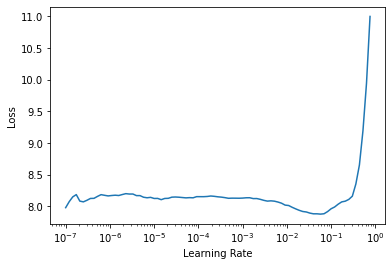

In [110]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.769311,4.310210,0.165436,0.365436,01:10
1,4.162461,3.208455,0.313737,0.576957,01:10
2,3.160325,2.573639,0.401477,0.692171,01:10
3,2.658620,2.267032,0.456425,0.740916,01:10
4,2.220916,2.066869,0.496898,0.781388,01:10
5,1.793351,1.913734,0.534417,0.803840,01:09
6,1.369767,1.772398,0.576366,0.827474,01:10
7,1.079784,1.696970,0.599705,0.839882,01:09
8,0.866847,1.668165,0.597637,0.845495,01:11
9,0.742026,1.659432,0.602068,0.848449,01:11


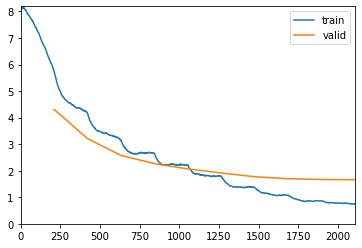

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b3.pth')

In [111]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b3')

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=7.585775847473997e-07)

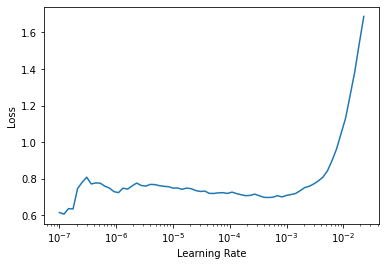

In [112]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.790697,1.663053,0.600000,0.845790,01:28
1,0.743184,1.650583,0.601477,0.849040,01:30
2,0.724635,1.640158,0.607386,0.849335,01:30
3,0.713320,1.642248,0.603250,0.851699,01:30
4,0.680949,1.642199,0.607090,0.852585,01:31
5,0.665626,1.635946,0.608272,0.852880,01:31
6,0.660092,1.636856,0.612112,0.852289,01:30
7,0.659276,1.634087,0.609749,0.851108,01:30
8,0.635988,1.631748,0.611521,0.853471,01:30
9,0.651397,1.633952,0.614180,0.853471,01:30


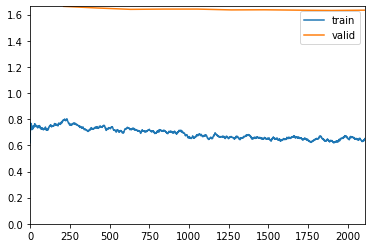

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b3.pth')

In [113]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b3')

### tf_efficientnet_b3 - Automatic Head Comparison

In [83]:
def tf_efficientnet_b3(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [84]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [85]:
random_seed(101,True)

Random state set:101, cuda used: True


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.007585775572806597)

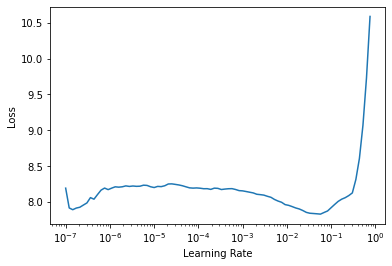

In [86]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.781148,4.279478,0.169572,0.371049,01:11
1,4.131817,3.251415,0.292467,0.567799,01:11
2,3.110221,2.579871,0.411817,0.688626,01:11
3,2.604053,2.332848,0.451994,0.728804,01:11
4,2.241992,2.122112,0.492467,0.774298,01:11
5,1.816635,1.941739,0.536780,0.798523,01:11
6,1.416960,1.802195,0.574594,0.826883,01:11
7,1.052722,1.719481,0.592319,0.838109,01:12
8,0.868104,1.703467,0.595569,0.841950,01:11
9,0.759323,1.689730,0.599114,0.845790,01:11


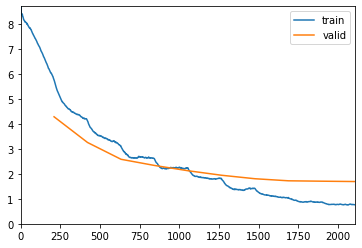

In [87]:
learn.fit_one_cycle(10, 1e-2)

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=4.786300905834651e-06)

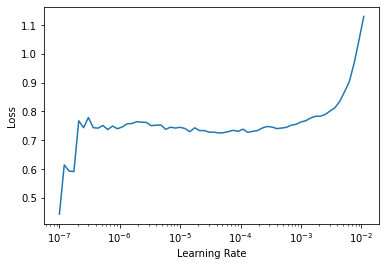

In [88]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.747167,1.692442,0.600000,0.845199,01:29
1,0.732580,1.682053,0.600295,0.849040,01:28
2,0.730926,1.666721,0.604727,0.846677,01:28
3,0.709243,1.672587,0.607976,0.847563,01:28
4,0.686407,1.669097,0.606204,0.846086,01:28
5,0.652349,1.664078,0.605318,0.849631,01:28
6,0.682894,1.661290,0.608863,0.851699,01:28
7,0.640753,1.661337,0.605022,0.849926,01:28
8,0.638063,1.661842,0.607976,0.849926,01:28
9,0.650807,1.662124,0.609453,0.847858,01:28


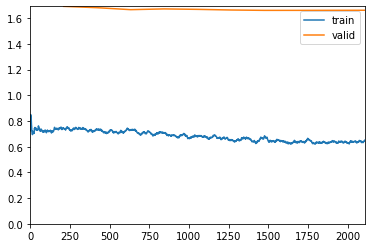

In [89]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))

### tf_efficientnet_b3 - Manual Head

In order to get exactly the same result as when using the automatic head, we will save the weights and biases generated by the automated head creation from the cnn_learner helper function. There are some additional random processes from the learner creation that would otherwise cause slightly different results in training. 

In [80]:
# Save the weights and biases from a fresh fast.ai created learner
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [81]:
list(learn.model.parameters())[-1]

Parameter containing:
tensor([[-0.1067, -0.0995, -0.0910,  ...,  0.0677, -0.0317, -0.1877],
        [-0.1150, -0.1037,  0.0075,  ..., -0.0040, -0.0678, -0.0380],
        [-0.0341,  0.0311, -0.0271,  ..., -0.1240,  0.0280, -0.0996],
        ...,
        [-0.0203,  0.0810, -0.0442,  ...,  0.1027, -0.0807,  0.0465],
        [-0.1826, -0.0106, -0.0049,  ..., -0.0205, -0.0011, -0.0027],
        [-0.0166,  0.0075,  0.0224,  ..., -0.1273,  0.0298, -0.0157]],
       requires_grad=True)

In [82]:
learn.save('tf_efficientnet_b3_baseline')

Path('/content/drive/My Drive/Houseplant Classifier/Models/tf_efficientnet_b3_baseline.pth')

Now we can generate the learner with the manual head and load in the saved weights and biases. 

In [71]:
def tf_efficientnet_b3(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [72]:
# Manually Build Head
custom_head = nn.Sequential(AdaptiveConcatPool2d(), 
                            Flatten(), 
                            nn.BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                            nn.Dropout(p=0.25, inplace=False),
                            nn.Linear(in_features=3072, out_features=512, bias=False), 
                            nn.ReLU(inplace=True),
                            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
                            nn.Dropout(p=0.5, inplace=False),
                            nn.Linear(in_features=512, out_features=517, bias=False))

In [73]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           custom_head = custom_head
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [74]:
learn.load('tf_efficientnet_b3_baseline')

We re-initialize the seeds to create the same 

In [75]:
random_seed(101,True)

Random state set:101, cuda used: True


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.007585775572806597)

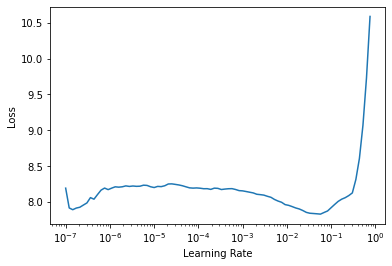

In [76]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.781148,4.279478,0.169572,0.371049,01:10
1,4.131817,3.251415,0.292467,0.567799,01:11
2,3.110221,2.579871,0.411817,0.688626,01:10
3,2.604053,2.332848,0.451994,0.728804,01:10
4,2.241992,2.122112,0.492467,0.774298,01:09
5,1.816635,1.941739,0.536780,0.798523,01:09
6,1.416960,1.802195,0.574594,0.826883,01:10
7,1.052722,1.719481,0.592319,0.838109,01:10
8,0.868104,1.703467,0.595569,0.841950,01:10
9,0.759323,1.689730,0.599114,0.845790,01:10


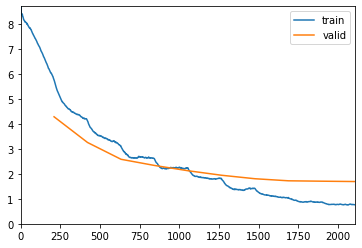

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b3-mh.pth')

In [77]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b3-mh')

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=4.786300905834651e-06)

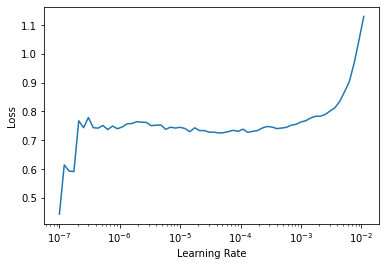

In [78]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.747167,1.692442,0.600000,0.845199,01:27
1,0.732580,1.682053,0.600295,0.849040,01:28
2,0.730926,1.666721,0.604727,0.846677,01:28
3,0.709243,1.672587,0.607976,0.847563,01:27
4,0.686407,1.669097,0.606204,0.846086,01:28
5,0.652349,1.664078,0.605318,0.849631,01:27
6,0.682894,1.661290,0.608863,0.851699,01:28
7,0.640753,1.661337,0.605022,0.849926,01:28
8,0.638063,1.661842,0.607976,0.849926,01:29
9,0.650807,1.662124,0.609453,0.847858,01:29


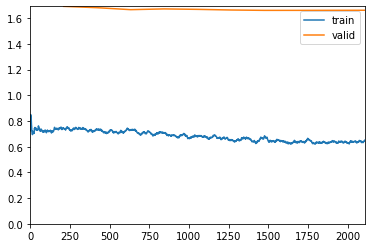

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b3-mh.pth')

In [79]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b3-mh')

### tf_efficientnet_b3 - Custom Split

In [114]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3_customsplit(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [115]:
# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b3_customsplit] = {'cut': -4, 
                           'split': _efficientnet_b3_split, 
                           'stats': imagenet_stats}

In [116]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.007585775572806597)

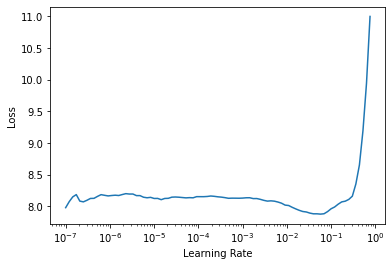

In [117]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.769311,4.310210,0.165436,0.365436,01:11
1,4.162461,3.208455,0.313737,0.576957,01:12
2,3.160325,2.573639,0.401477,0.692171,01:12
3,2.658620,2.267032,0.456425,0.740916,01:12
4,2.220916,2.066869,0.496898,0.781388,01:12
5,1.793351,1.913734,0.534417,0.803840,01:12
6,1.369767,1.772398,0.576366,0.827474,01:12
7,1.079784,1.696970,0.599705,0.839882,01:12
8,0.866847,1.668165,0.597637,0.845495,01:11
9,0.742026,1.659432,0.602068,0.848449,01:11


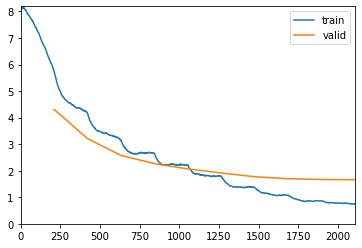

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b3-customsplit.pth')

In [118]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b3-customsplit')

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=4.786300996784121e-05, lr_steep=7.585775847473997e-07)

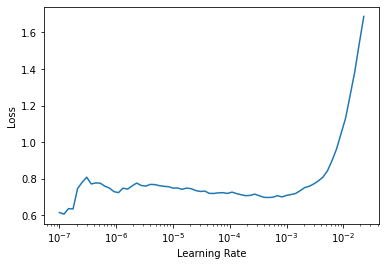

In [119]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.790961,1.661644,0.599114,0.846086,01:28
1,0.741772,1.644700,0.605022,0.849335,01:28
2,0.713109,1.627440,0.610931,0.851108,01:28
3,0.682678,1.626361,0.611226,0.853176,01:29
4,0.633316,1.619772,0.610340,0.854062,01:28
5,0.605522,1.614379,0.616248,0.855244,01:28
6,0.587482,1.615693,0.619202,0.855244,01:28
7,0.579769,1.610785,0.619793,0.851994,01:27
8,0.553402,1.609323,0.617134,0.855539,01:27
9,0.561582,1.611271,0.617725,0.855539,01:28


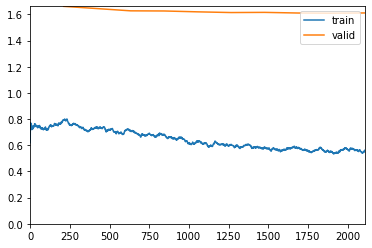

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b3-customsplit.pth')

In [120]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b3-customsplit')

### tf_efficientnet_b3_ns -  Ported TF Weights (NoisyStudent)

In [ ]:
def tf_efficientnet_b3_ns(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_ns',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=1.5848931980144698e-06)

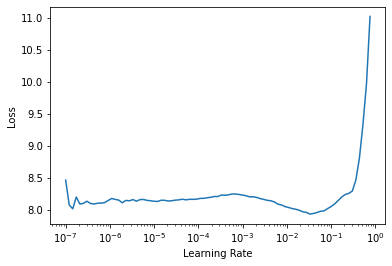

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.940581,4.426753,0.156278,0.353028,01:13
1,4.144099,3.208781,0.308419,0.574298,01:12
2,3.117344,2.532260,0.410635,0.694239,01:12
3,2.625613,2.162081,0.473264,0.767208,01:12
4,2.190526,1.949794,0.512260,0.794682,01:12
5,1.804500,1.795969,0.558346,0.822157,01:12
6,1.433107,1.628422,0.592024,0.852585,01:12
7,1.127114,1.537620,0.615953,0.863220,01:12
8,0.922466,1.512376,0.622747,0.869424,01:13
9,0.806739,1.500105,0.625406,0.867061,01:13


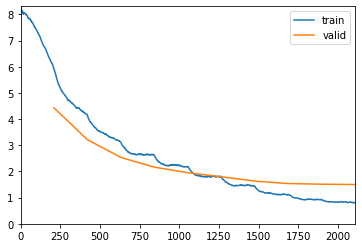

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b3_ns.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b3_ns')

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=1.3182567499825382e-06)

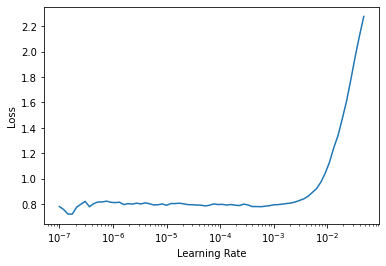

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.807445,1.507550,0.620679,0.871492,01:33
1,0.807704,1.492890,0.632201,0.870015,01:32
2,0.778214,1.484636,0.630724,0.870310,01:32
3,0.752764,1.490096,0.631905,0.871196,01:32
4,0.730897,1.484702,0.633087,0.871787,01:32
5,0.713409,1.473576,0.632496,0.872378,01:32
6,0.727644,1.473588,0.631905,0.874446,01:32
7,0.746743,1.476042,0.631905,0.875923,01:32
8,0.720314,1.476131,0.632792,0.873264,01:32
9,0.697057,1.473344,0.633973,0.875628,01:32


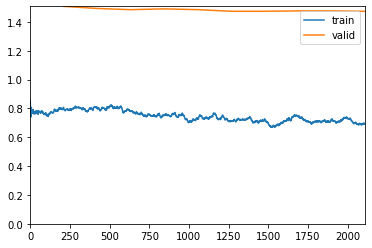

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b3_ns.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b3_ns')

### tf_efficientnet_b3_ns - Custom Split

In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b3_ns_customsplit(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b3_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b3_ns_customsplit] = {'cut': -4, 
                           'split': _efficientnet_b3_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_ns_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=1.5848931980144698e-06)

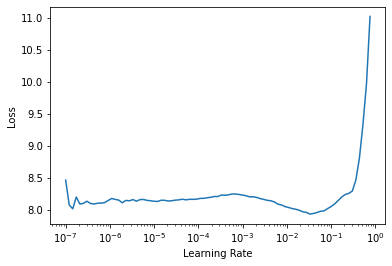

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.940581,4.426753,0.156278,0.353028,01:13
1,4.144099,3.208781,0.308419,0.574298,01:12
2,3.117344,2.532260,0.410635,0.694239,01:12
3,2.625613,2.162081,0.473264,0.767208,01:12
4,2.190526,1.949794,0.512260,0.794682,01:12
5,1.804500,1.795969,0.558346,0.822157,01:12
6,1.433107,1.628422,0.592024,0.852585,01:12
7,1.127114,1.537620,0.615953,0.863220,01:12
8,0.922466,1.512376,0.622747,0.869424,01:12
9,0.806739,1.500105,0.625406,0.867061,01:12


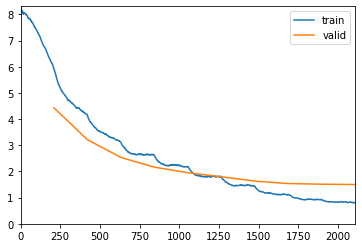

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b3_ns-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b3_ns-customsplit')

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=1.3182567499825382e-06)

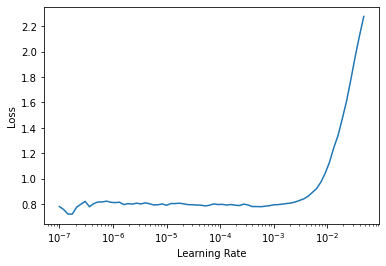

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.807380,1.504624,0.620975,0.870310,01:31
1,0.807065,1.485539,0.632496,0.867947,01:31
2,0.766369,1.473707,0.631019,0.874151,01:30
3,0.727319,1.473287,0.635155,0.873855,01:31
4,0.687094,1.468146,0.637518,0.873560,01:31
5,0.658926,1.454371,0.638405,0.874741,01:31
6,0.658135,1.450536,0.638109,0.878877,01:32
7,0.667989,1.452155,0.636928,0.878582,01:32
8,0.635199,1.451551,0.638405,0.876219,01:32
9,0.615293,1.449039,0.638405,0.878287,01:31


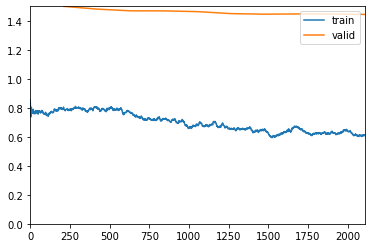

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b3_ns-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b3_ns-customsplit')

### tf_efficientnet_b5 (bs=44)


In [ ]:
def tf_efficientnet_b5(pretrained = False):
  model = geffnet.tf_efficientnet_b5(pretrained=pretrained, drop_rate=0.4, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b5',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs = 44
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
30,711,856 total parameters.
2,543,808 training parameters.


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=1.0964781722577754e-06)

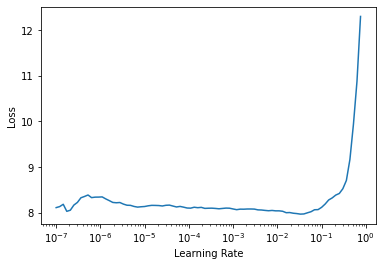

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.141208,4.873058,0.105761,0.260857,01:57
1,4.431232,3.622287,0.235451,0.502511,01:57
2,3.364793,2.870188,0.354505,0.624815,01:57
3,2.835897,2.439092,0.424815,0.719055,01:57
4,2.410502,2.166371,0.483900,0.758346,01:58
5,1.957211,1.978583,0.519350,0.792910,01:57
6,1.554722,1.830842,0.562186,0.813885,01:58
7,1.204011,1.779624,0.578434,0.822452,01:58
8,1.021929,1.737119,0.589660,0.834860,01:57
9,0.835216,1.724904,0.592319,0.834860,01:57


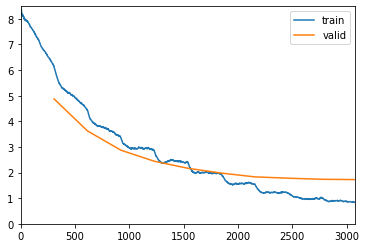

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b5.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b5')

Unfreezing model body
30,711,856 total parameters.
30,711,856 training parameters.


SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=2.2908675418875646e-06)

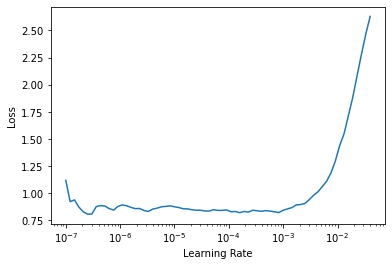

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.871608,1.734952,0.590251,0.832792,02:38
1,0.828761,1.707956,0.601773,0.837223,02:37
2,0.835317,1.700318,0.603250,0.838405,02:38
3,0.798205,1.707393,0.599705,0.837518,02:38
4,0.784306,1.701596,0.600295,0.838996,02:37
5,0.735169,1.688136,0.602363,0.840768,02:37
6,0.717653,1.687907,0.604136,0.842836,02:38
7,0.706211,1.682998,0.609453,0.839882,02:37
8,0.697109,1.695378,0.605908,0.838996,02:38
9,0.733687,1.693351,0.602363,0.838405,02:37


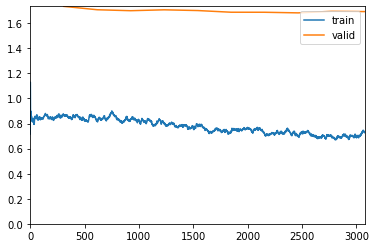

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b5.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b5')

### tf_efficientnet_b5 - Custom Split

In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b5_customsplit(pretrained = False):
  model = geffnet.tf_efficientnet_b5(pretrained=pretrained, drop_rate=0.4, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b5_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b5_customsplit] = {'cut': -4, 
                           'split': _efficientnet_b5_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b5_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs = 44
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
30,711,856 total parameters.
30,711,856 training parameters.
---------1 Groups Frozen--------
30,711,856 total parameters.
28,655,040 training parameters.
---------2 Groups Frozen--------
30,711,856 total parameters.
2,543,808 training parameters.
---------3 Groups Frozen--------
30,711,856 total parameters.
181,952 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


Freezing model body
30,711,856 total parameters.
2,543,808 training parameters.


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=1.0964781722577754e-06)

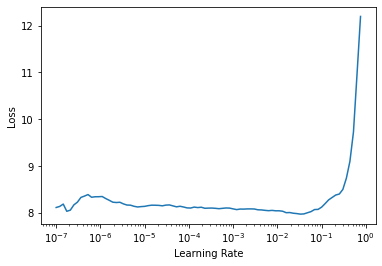

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.141208,4.873058,0.105761,0.260857,01:57
1,4.431232,3.622287,0.235451,0.502511,01:56
2,3.364793,2.870188,0.354505,0.624815,01:57
3,2.835897,2.439092,0.424815,0.719055,01:56
4,2.410502,2.166371,0.483900,0.758346,01:56
5,1.957211,1.978583,0.519350,0.792910,01:57
6,1.554722,1.830842,0.562186,0.813885,01:57
7,1.204011,1.779624,0.578434,0.822452,01:56
8,1.021929,1.737119,0.589660,0.834860,01:57
9,0.835216,1.724904,0.592319,0.834860,01:57


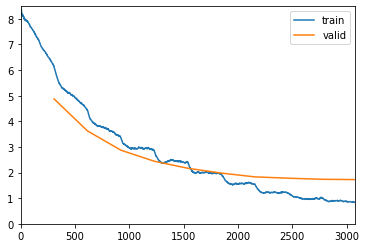

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b5-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b5-customsplit')

Unfreezing model body
30,711,856 total parameters.
30,711,856 training parameters.


SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=2.2908675418875646e-06)

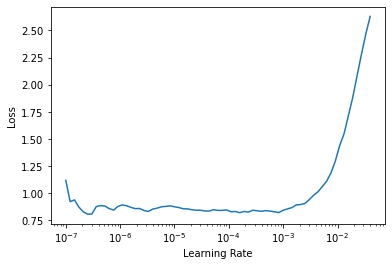

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.871985,1.733471,0.590842,0.832201,02:39
1,0.831325,1.702810,0.602363,0.836928,02:38
2,0.822613,1.690356,0.603250,0.838405,02:39
3,0.758938,1.695519,0.603545,0.838700,02:39
4,0.709675,1.679160,0.607386,0.839586,02:39
5,0.645059,1.665538,0.608567,0.843131,02:39
6,0.602333,1.659395,0.612703,0.843427,02:38
7,0.568323,1.655368,0.616839,0.845790,02:38
8,0.559518,1.666912,0.612112,0.844313,02:38
9,0.588595,1.665580,0.614180,0.841654,02:38


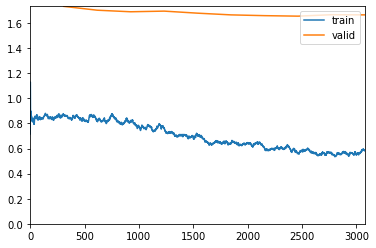

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b5-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b5-customsplit')

### tf_efficientnet_b5_ns -  Ported TF Weights (NoisyStudent)

In [ ]:
def tf_efficientnet_b5_ns(pretrained = False):
  model = geffnet.tf_efficientnet_b5_ns(pretrained=pretrained, drop_rate=0.4, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b5_ns',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs = 44
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
30,711,856 total parameters.
2,543,808 training parameters.


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=4.786300905834651e-06)

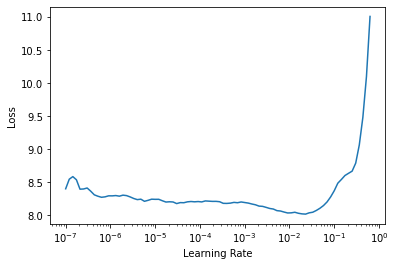

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.933710,4.614457,0.128804,0.302216,01:58
1,4.162071,3.331223,0.279173,0.553324,01:58
2,3.158975,2.645725,0.385820,0.674742,01:58
3,2.636955,2.235039,0.462629,0.755391,01:57
4,2.218978,1.933700,0.520532,0.800591,01:57
5,1.812497,1.746294,0.566322,0.830724,01:57
6,1.450422,1.587065,0.594682,0.857607,01:57
7,1.120342,1.505307,0.620089,0.863515,01:57
8,0.934182,1.465359,0.633383,0.868833,01:57
9,0.814313,1.454262,0.633973,0.870310,01:57


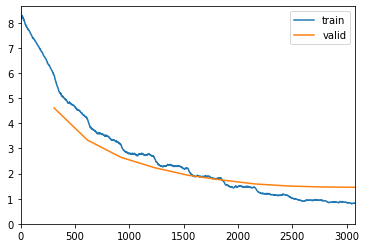

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b5_ns.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b5_ns')

Unfreezing model body
30,711,856 total parameters.
30,711,856 training parameters.


SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=1.5848931980144698e-06)

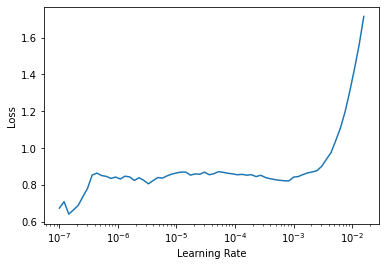

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.849759,1.455905,0.636632,0.873855,02:38
1,0.798254,1.447725,0.635155,0.871196,02:38
2,0.807183,1.428891,0.639291,0.875037,02:38
3,0.778594,1.429717,0.639291,0.874446,02:38
4,0.748516,1.431018,0.645790,0.873264,02:39
5,0.718096,1.414719,0.647563,0.875628,02:39
6,0.696639,1.419586,0.647858,0.874741,02:40
7,0.702671,1.411227,0.647267,0.878287,02:39
8,0.696279,1.415352,0.649040,0.879468,02:39
9,0.689738,1.408003,0.649631,0.874446,02:39


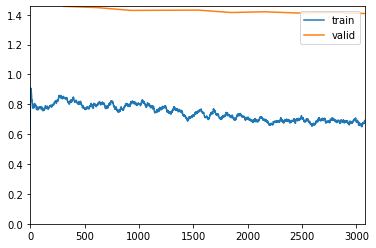

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b5_ns.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b5_ns')

### tf_efficientnet_b5_ns - Custom Split

In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b5_ns_customsplit(pretrained = False):
  model = geffnet.tf_efficientnet_b5_ns(pretrained=pretrained, drop_rate=0.4, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b5_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b5_ns_customsplit] = {'cut': -4, 
                           'split': _efficientnet_b5_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b5_ns_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs = 44
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
30,711,856 total parameters.
30,711,856 training parameters.
---------1 Groups Frozen--------
30,711,856 total parameters.
28,655,040 training parameters.
---------2 Groups Frozen--------
30,711,856 total parameters.
2,543,808 training parameters.
---------3 Groups Frozen--------
30,711,856 total parameters.
181,952 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


In [ ]:
# The model has this many groups of layers
len(learn.opt.param_lists)

3

Freezing model body
30,711,856 total parameters.
2,543,808 training parameters.


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=4.786300905834651e-06)

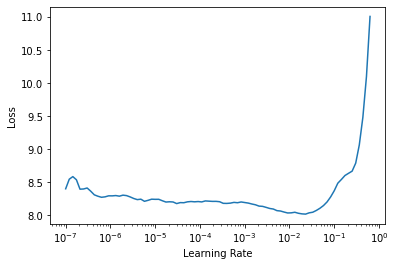

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.933710,4.614457,0.128804,0.302216,01:58
1,4.162071,3.331223,0.279173,0.553324,01:58
2,3.158975,2.645725,0.385820,0.674742,01:58
3,2.636955,2.235039,0.462629,0.755391,01:58
4,2.218978,1.933700,0.520532,0.800591,01:58
5,1.812497,1.746294,0.566322,0.830724,01:58
6,1.450422,1.587065,0.594682,0.857607,01:58
7,1.120342,1.505307,0.620089,0.863515,01:58
8,0.934182,1.465359,0.633383,0.868833,01:58
9,0.814313,1.454262,0.633973,0.870310,01:58


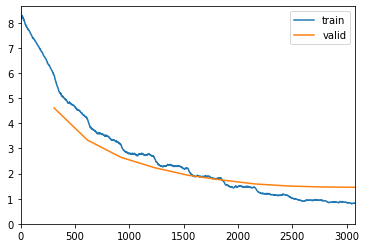

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b5_ns-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b5_ns-customsplit')

Unfreezing model body
30,711,856 total parameters.
30,711,856 training parameters.


SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=1.5848931980144698e-06)

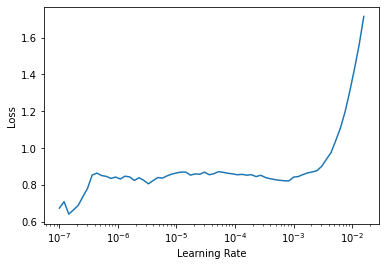

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.850475,1.452003,0.636928,0.874151,02:39
1,0.803473,1.444315,0.634269,0.870901,02:39
2,0.798048,1.416841,0.641654,0.877105,02:38
3,0.738679,1.412243,0.645495,0.875037,02:38
4,0.686880,1.415660,0.649631,0.874741,02:39
5,0.635426,1.385763,0.652290,0.879468,02:39
6,0.594157,1.389513,0.654653,0.880059,02:38
7,0.580027,1.378733,0.659084,0.881536,02:39
8,0.574596,1.385849,0.658198,0.881241,02:38
9,0.556665,1.375754,0.658493,0.878287,02:40


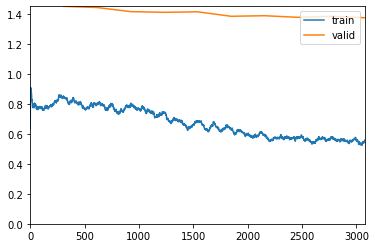

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b5_ns-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b5_ns-customsplit')

### tf_efficientnet_b7 (bs=24)

In [ ]:
def tf_efficientnet_b7(pretrained = False):
  model = geffnet.tf_efficientnet_b7(pretrained=pretrained, drop_rate=0.5, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b7',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs = 24
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
66,684,368 total parameters.
3,208,128 training parameters.


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=1.9054607491852948e-06)

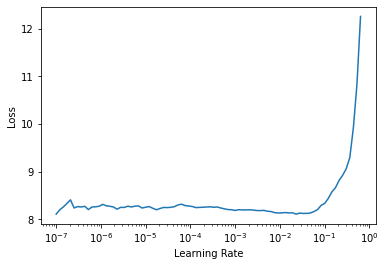

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.112365,5.147415,0.076514,0.215657,03:30
1,4.546440,3.913046,0.192910,0.442836,03:31
2,3.680542,3.101713,0.315214,0.589660,03:29
3,3.188309,2.574471,0.404431,0.687149,03:29
4,2.772530,2.319136,0.450812,0.744165,03:29
5,2.379794,2.049219,0.516987,0.781093,03:29
6,1.916783,1.899641,0.547415,0.807386,03:29
7,1.518555,1.805202,0.566322,0.823634,03:29
8,1.265558,1.751975,0.590842,0.829542,03:29
9,1.116985,1.744156,0.590842,0.828656,03:29


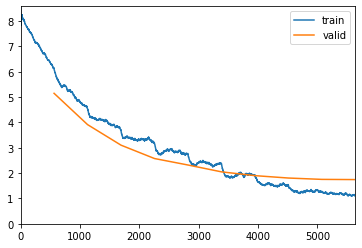

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b7.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b7')

Unfreezing model body
66,684,368 total parameters.
66,684,368 training parameters.


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.0964781722577754e-06)

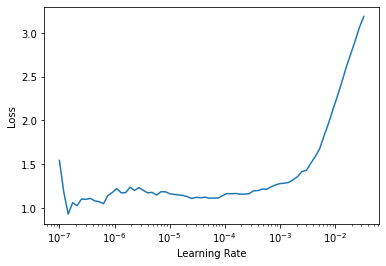

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.215347,1.744949,0.589069,0.831610,05:03
1,1.182196,1.731186,0.589956,0.829542,05:03
2,1.136606,1.721153,0.590547,0.831905,05:04
3,1.073187,1.710816,0.593796,0.835746,05:03
4,1.006250,1.693035,0.595864,0.841359,05:03
5,0.965591,1.691409,0.600000,0.840768,05:03
6,0.912728,1.688535,0.600295,0.840768,05:03
7,0.900665,1.670933,0.602068,0.844904,05:02
8,0.918930,1.688563,0.600295,0.843131,05:04
9,0.916054,1.684569,0.599409,0.844904,05:05


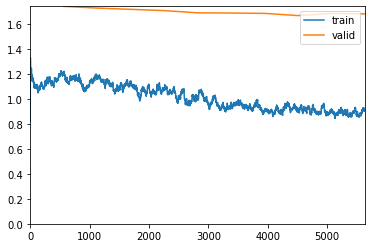

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b7.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b7')

### tf_efficientnet_b7 - Custom Split

In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace   
def tf_efficientnet_b7_customsplit(pretrained = False):
  model = geffnet.tf_efficientnet_b7(pretrained=pretrained, drop_rate=0.5, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b7_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b7_customsplit] = {'cut': -4, 
                           'split': _efficientnet_b7_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b7_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs = 24
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

====Examining frozen layers.====
---------0 Groups Frozen--------
66,684,368 total parameters.
66,684,368 training parameters.
---------1 Groups Frozen--------
66,684,368 total parameters.
62,042,968 training parameters.
---------2 Groups Frozen--------
66,684,368 total parameters.
3,208,128 training parameters.
---------3 Groups Frozen--------
66,684,368 total parameters.
321,984 training parameters.
--------------------------------


/usr/local/lib/python3.6/dist-packages/fastai/optimizer.py:22: UserWarning: Freezing 3 groups; model has 3; whole model is frozen.
  warn(f"Freezing {self.frozen_idx} groups; model has {len(self.param_lists)}; whole model is frozen.")


In [ ]:
# The model has this many groups of layers
len(learn.opt.param_lists)

3

Freezing model body
66,684,368 total parameters.
3,208,128 training parameters.


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=1.9054607491852948e-06)

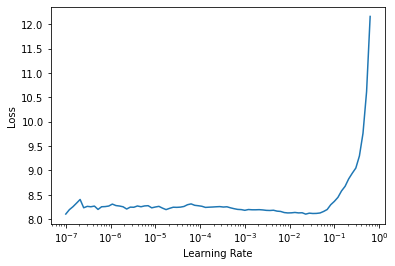

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.112365,5.147415,0.076514,0.215657,03:30
1,4.546440,3.913046,0.192910,0.442836,03:31
2,3.680542,3.101713,0.315214,0.589660,03:31
3,3.188309,2.574471,0.404431,0.687149,03:31
4,2.772530,2.319136,0.450812,0.744165,03:31
5,2.379794,2.049219,0.516987,0.781093,03:31
6,1.916783,1.899641,0.547415,0.807386,03:31
7,1.518555,1.805202,0.566322,0.823634,03:31
8,1.265558,1.751975,0.590842,0.829542,03:31
9,1.116985,1.744156,0.590842,0.828656,03:30


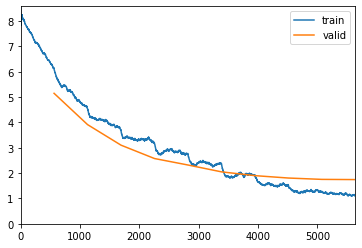

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b7-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b7-customsplit')

Unfreezing model body
66,684,368 total parameters.
66,684,368 training parameters.


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.0964781722577754e-06)

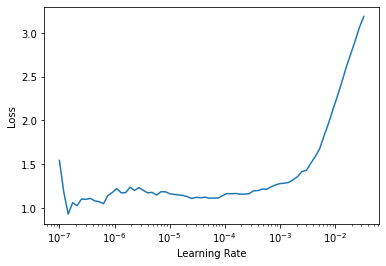

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.219691,1.743667,0.589069,0.830133,05:05
1,1.206778,1.729280,0.588183,0.833087,05:07
2,1.134682,1.719392,0.592319,0.835155,05:05
3,1.029019,1.685367,0.598523,0.839291,05:05
4,0.908326,1.669993,0.602954,0.843131,05:06
5,0.820193,1.668364,0.604136,0.846972,05:06
6,0.737786,1.662069,0.604727,0.847563,05:06
7,0.698298,1.639860,0.611817,0.851994,05:05
8,0.695591,1.656991,0.613589,0.845790,05:06
9,0.680865,1.650372,0.610340,0.854653,05:07


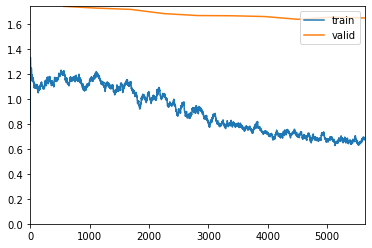

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b7-customsplit.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b7-customsplit')

### tf_efficientnet_b7_ns -  Ported TF Weights (NoisyStudent)

In [ ]:
def tf_efficientnet_b7_ns(pretrained = False):
  model = geffnet.tf_efficientnet_b7_ns(pretrained=pretrained, drop_rate=0.5, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b7_ns',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs = 24
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
66,684,368 total parameters.
3,208,128 training parameters.


SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=1.3182567499825382e-06)

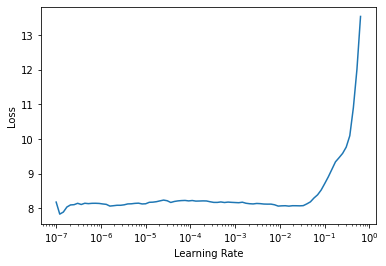

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.391562,5.400916,0.053767,0.153914,03:32
1,4.645294,4.103182,0.169867,0.394682,03:31
2,3.668202,3.056560,0.325554,0.610340,03:31
3,3.088949,2.508519,0.409749,0.696898,03:30
4,2.769470,2.149539,0.484195,0.768981,03:29
5,2.275414,1.904619,0.538552,0.808567,03:28
6,1.923222,1.700709,0.588183,0.830724,03:27
7,1.519093,1.590844,0.606499,0.846086,03:27
8,1.300608,1.537760,0.617430,0.852880,03:27
9,1.228736,1.522958,0.617134,0.857607,03:27


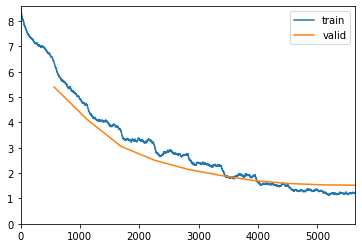

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-1-quick-geffnet-tf_efficientnet_b7_ns.pth')

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b7_ns')

Unfreezing model body
66,684,368 total parameters.
66,684,368 training parameters.


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.311311274956097e-06)

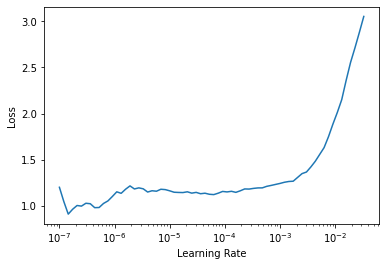

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.203399,1.526049,0.622747,0.853176,04:59
1,1.131674,1.507112,0.625997,0.862038,05:00
2,1.108456,1.496409,0.618316,0.861152,05:03
3,1.067215,1.484235,0.626883,0.859675,05:02
4,1.053023,1.479483,0.634269,0.859675,05:02
5,1.006956,1.467137,0.634269,0.862629,05:01
6,0.940424,1.471102,0.639882,0.863811,05:00
7,0.969907,1.453462,0.641359,0.864993,04:59
8,0.918695,1.479844,0.633678,0.864993,05:00
9,0.967079,1.456429,0.633973,0.865583,05:01


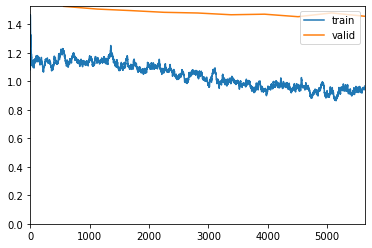

Path('/content/drive/My Drive/Houseplant Classifier/Models/stage-2-quick-geffnet-tf_efficientnet_b7_ns.pth')

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b7_ns')

### tf_efficientnet_b7_ns - Custom Split

In [ ]:
# We wrap the PyTorchCV implementation into the torchvision model API
# Each model should be present as a function in the global namespace 
def tf_efficientnet_b7_ns_customsplit(pretrained = False):
  model = geffnet.tf_efficientnet_b7_ns(pretrained=pretrained, drop_rate=0.5, drop_connect_rate=0.2, as_sequential=True)
  return model

In [ ]:
# Recall we want to cut at -4, and split to give roughly 5% of parameters in the first group
def _efficientnet_b7_split(m): return L(m[0][:7], m[0][7:], m[1:]).map(params)

model_meta[tf_efficientnet_b7_ns_customsplit] = {'cut': -4, 
                           'split': _efficientnet_b7_split, 
                           'stats': imagenet_stats}

In [ ]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b7_ns_customsplit',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs = 24
                           )

In [ ]:
print('====Examining frozen layers.====')
print('---------0 Groups Frozen--------')
learn.freeze_to(0)
enumerate_params(learn)
print('---------1 Groups Frozen--------')
learn.freeze_to(1)
enumerate_params(learn)
print('---------2 Groups Frozen--------')
learn.freeze_to(2)
enumerate_params(learn)
print('---------3 Groups Frozen--------')
learn.freeze_to(3)
enumerate_params(learn)
print('--------------------------------')

In [ ]:
# The model has this many groups of layers
len(learn.opt.param_lists)

In [ ]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, 1e-2)
learn.save('stage-1-quick-geffnet-tf_efficientnet_b7_ns-customsplit')

In [ ]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
learn.save('stage-2-quick-geffnet-tf_efficientnet_b7_ns-customsplit')

# Standardizing Batch Size

### tf_efficientnet_b3 (bs=32)

In [121]:
def tf_efficientnet_b3(pretrained = False):
  model = geffnet.tf_efficientnet_b3(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [122]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs = 32
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.010964781977236271)

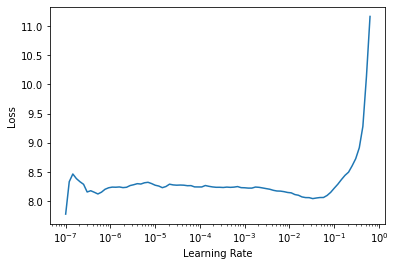

In [123]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.262071,4.306910,0.171049,0.369867,01:23
1,4.111383,3.337641,0.277991,0.548301,01:23
2,3.273884,2.766676,0.371344,0.667651,01:22
3,2.856613,2.378939,0.437814,0.725554,01:22
4,2.457118,2.129818,0.488035,0.773708,01:21
5,2.043141,1.950389,0.545347,0.794387,01:22
6,1.649038,1.764705,0.564845,0.827474,01:22
7,1.277985,1.665081,0.605908,0.836632,01:21
8,1.051360,1.634402,0.602659,0.845790,01:21
9,0.961837,1.626413,0.607090,0.848154,01:22


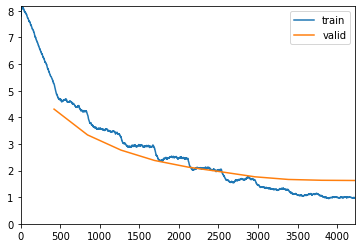

In [124]:
learn.fit_one_cycle(10, 1e-2)

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=1.2022644114040304e-06, lr_steep=1.3182567499825382e-06)

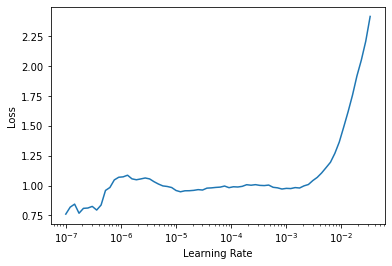

In [125]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.988342,1.635807,0.602363,0.846972,01:49
1,0.990645,1.619386,0.606499,0.850812,01:50
2,0.971653,1.601104,0.609453,0.850812,01:48
3,0.900597,1.592494,0.612999,0.851108,01:49
4,0.886991,1.593830,0.613294,0.856130,01:48
5,0.861093,1.588207,0.616839,0.853471,01:50
6,0.807323,1.596552,0.617725,0.853176,01:51
7,0.849008,1.578398,0.619202,0.858789,01:52
8,0.844096,1.594928,0.615953,0.853176,01:52
9,0.834562,1.585109,0.619793,0.857016,01:53


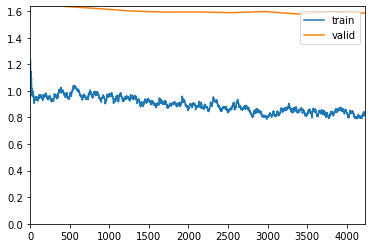

In [126]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))

### tf_efficientnet_b3_ns (bs=32)

In [127]:
def tf_efficientnet_b3_ns(pretrained = False):
  model = geffnet.tf_efficientnet_b3_ns(pretrained=pretrained, drop_rate=0.3, drop_connect_rate=0.2, as_sequential=True)
  return model

In [128]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b3_ns',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs=32
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
12,540,968 total parameters.
1,932,032 training parameters.


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=7.585775847473997e-07)

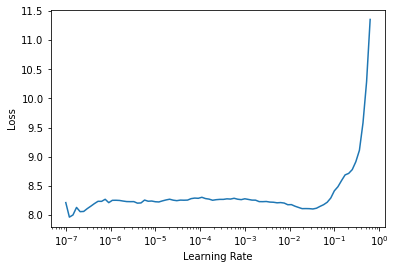

In [129]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.433706,4.402308,0.158346,0.358346,01:27
1,4.024841,3.280524,0.286263,0.558346,01:26
2,3.202871,2.702780,0.367504,0.672969,01:27
3,2.764191,2.246215,0.457607,0.750074,01:26
4,2.468789,1.965875,0.518759,0.792614,01:27
5,1.969643,1.789788,0.565731,0.826292,01:27
6,1.693412,1.597678,0.601182,0.846972,01:27
7,1.341894,1.506645,0.630724,0.860857,01:26
8,1.134734,1.465334,0.637814,0.873855,01:26
9,0.986873,1.450914,0.638405,0.876809,01:26


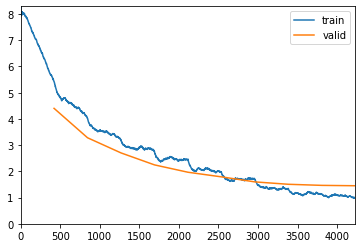

In [130]:
learn.fit_one_cycle(10, 1e-2)

Unfreezing model body
12,540,968 total parameters.
12,540,968 training parameters.


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=8.31763736641733e-06)

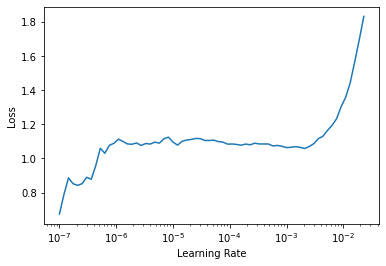

In [131]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.021815,1.457455,0.637814,0.872083,01:53
1,1.000689,1.440928,0.642836,0.875332,01:53
2,1.005044,1.432694,0.643722,0.876809,01:53
3,0.990253,1.432308,0.641064,0.875332,01:52
4,0.969829,1.430148,0.644313,0.877991,01:53
5,0.893459,1.421971,0.643722,0.874741,01:54
6,0.897723,1.427973,0.647563,0.879468,01:53
7,0.906547,1.417489,0.645790,0.880355,01:53
8,0.896230,1.428205,0.647563,0.878582,01:54
9,0.902067,1.416126,0.648154,0.880059,01:52


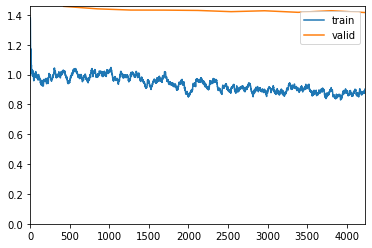

In [132]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))

### tf_efficientnet_b5 (bs=32)


In [133]:
def tf_efficientnet_b5(pretrained = False):
  model = geffnet.tf_efficientnet_b5(pretrained=pretrained, drop_rate=0.4, drop_connect_rate=0.2, as_sequential=True)
  return model

In [134]:
learn = create_cnn_learner(pct_images=0.25, 
                           deterministic=True, 
                           size=224, 
                           arch = 'tf_efficientnet_b5',
                           pretrained=True,
                           img_path ='/content/plant_images_database_manualcleanedlosses10/', 
                           split_path = '/content/plant_image_database/',
                           bs = 32
                           )

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_images_database_manualcleanedlosses10/, using 25.00% of the images (16940 images.) Shuffle = False.
We have 517 classes, with a training set of size 13555, and a validation set of size 3385
The main split has 80.00% training data with 518 classes, the reduced split has 80.02 % training data, with 517 classes.


Freezing model body
30,711,856 total parameters.
2,543,808 training parameters.


SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=6.309573450380412e-07)

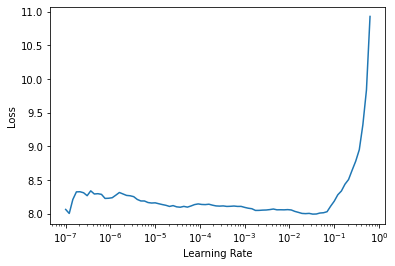

In [135]:
print(f'Freezing model body')
learn.freeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,5.894603,4.926075,0.104874,0.257607,02:05
1,4.398564,3.611929,0.237518,0.496012,02:04
2,3.464575,2.940827,0.345643,0.620679,02:04
3,2.985748,2.519223,0.410340,0.704284,02:04
4,2.578254,2.187515,0.476809,0.764254,02:05
5,2.142724,2.000207,0.524077,0.795864,02:05
6,1.726319,1.823812,0.558050,0.817430,02:05
7,1.376342,1.747695,0.575480,0.827770,02:04
8,1.194893,1.701899,0.582866,0.838996,02:04
9,1.024311,1.692521,0.592024,0.839291,02:04


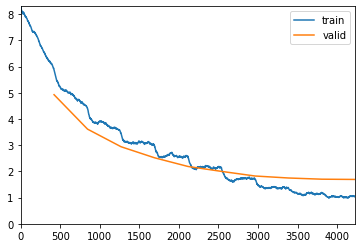

In [136]:
learn.fit_one_cycle(10, 1e-2)

Unfreezing model body
30,711,856 total parameters.
30,711,856 training parameters.


SuggestedLRs(lr_min=8.317637839354575e-05, lr_steep=2.2908675418875646e-06)

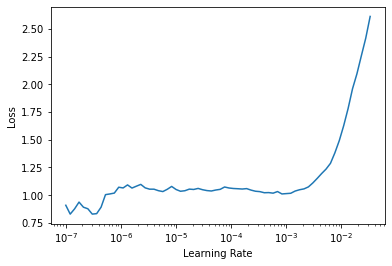

In [137]:
print(f'Unfreezing model body')
learn.unfreeze()
enumerate_params(learn)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.031940,1.697790,0.585524,0.838405,02:52
1,1.015097,1.676792,0.594682,0.838996,02:52
2,0.968590,1.666540,0.594978,0.844313,02:51
3,0.929089,1.663168,0.603545,0.841063,02:50
4,0.887497,1.653403,0.604431,0.843131,02:52
5,0.879394,1.650696,0.603250,0.846972,02:52
6,0.855522,1.644965,0.610340,0.846086,02:53
7,0.828335,1.640861,0.607976,0.843722,02:54
8,0.814158,1.655639,0.602954,0.844609,02:54
9,0.826009,1.646181,0.605022,0.845495,02:53


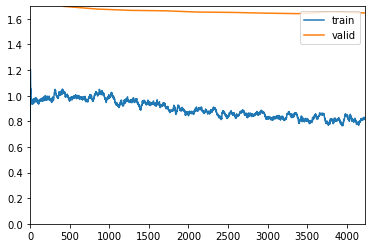

In [138]:
learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))